# Anomaly Detection Using Autoencoders

The goal of this project is to detect anomalies on the desired dataset using an autoencoder architecture. For this architecture, the number of nodes, layers and type of layers will be varied to achieve the best result.

Because of the high dimensionality of the dataset, PCA will be used for dimensionality reduction, applying the autoenconder to the most important principal components. Later, using the correlation of the columns with the most important principal component, it will be possible to plot some of the columns and it's reconstructions, marking the anomalies for later analysis.

## Imports

In [1]:
cd ../../

/mnt/c/Users/victo/Documents/Repos/neural-networks


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.utils.vis_utils import plot_model
import tensorflow as tf
from tensorflow.keras import regularizers

In [3]:
from utils.data_manipulation import Data
from utils.data_visualization import DataViz

## The Dataset

The choosen dataset is located in this link: https://www.kaggle.com/nphantawee/pump-sensor-data.
It's a collection of 52 sensors that monitorates a water pump machine. This sensors are all float values and can indicate anomalies and breakage of the pump. To aid on this detection, there is a column "machine_status", marking if the pump is broken, recovering or running.

In [4]:
pump_data = pd.read_csv("datasets/sensor.csv", sep=",")
pump_data.reset_index(drop=True, inplace=True)
pump_data = pump_data.drop(["Unnamed: 0"], axis=1)
display(pump_data)

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,2018-04-01 00:00:00,2.465394,47.09201,53.211800,46.310760,634.375000,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,2018-04-01 00:01:00,2.465394,47.09201,53.211800,46.310760,634.375000,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2018-04-01 00:02:00,2.444734,47.35243,53.211800,46.397570,638.888900,73.54598,13.32465,16.03733,15.61777,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,2018-04-01 00:03:00,2.460474,47.09201,53.168400,46.397568,628.125000,76.98898,13.31742,16.24711,15.69734,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,2018-04-01 00:04:00,2.445718,47.13541,53.211800,46.397568,636.458300,76.58897,13.35359,16.21094,15.69734,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220315,2018-08-31 23:55:00,2.407350,47.69965,50.520830,43.142361,634.722229,64.59095,15.11863,16.65220,15.65393,...,38.28125,68.287030,52.37268,48.32176,41.087960,212.3843,153.64580,NaN,231.1921,NORMAL
220316,2018-08-31 23:56:00,2.400463,47.69965,50.564240,43.142361,630.902771,65.83363,15.15480,16.70284,15.65393,...,38.28125,66.840280,50.63657,48.03241,40.798610,213.8310,156.25000,NaN,231.1921,NORMAL
220317,2018-08-31 23:57:00,2.396528,47.69965,50.520830,43.142361,625.925903,67.29445,15.08970,16.70284,15.69734,...,39.06250,65.393520,48.90046,48.03241,40.798610,217.3032,155.38190,NaN,232.0602,NORMAL
220318,2018-08-31 23:58:00,2.406366,47.69965,50.520832,43.142361,635.648100,65.09175,15.11863,16.56539,15.74074,...,40.62500,64.236110,47.74306,48.32176,40.509258,222.5116,153.93520,NaN,234.0856,NORMAL


### Fix missing values

Fill null fields with the mean value of the column and remove invalid columns.

In [5]:
pump_data = pump_data.fillna(pump_data.mean())
pump_data = pump_data.drop(["sensor_15"], axis=1)

### Plot of a Sensor Data and Breakage Points

Timeseries plotting of the sensor #0 and #1, with the breakage points highlited as red dots.

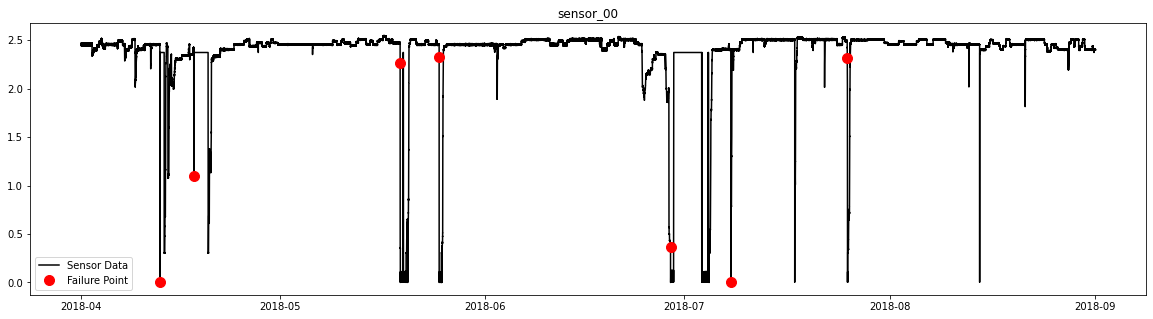

In [6]:
pd.options.mode.chained_assignment = None
# plt.rcParams.update({'font.size': 22})

broken_markers = pump_data[pump_data["machine_status"] == "BROKEN"]
broken_markers["timestamp"] = pd.to_datetime(broken_markers["timestamp"])
timestamps = list(pd.to_datetime(pump_data["timestamp"]).to_numpy())
pump_data_sensors_only = pump_data.drop(["machine_status", "timestamp"], axis=1)
plt.figure(figsize=(20,5))
plt.plot(timestamps, pump_data_sensors_only["sensor_00"], color="black", label="Sensor Data")
plt.plot(broken_markers["timestamp"], broken_markers["sensor_00"], linestyle='none', marker='o', color='red', markersize=10, label="Failure Point")
plt.title("sensor_00")
plt.legend()
plt.show()

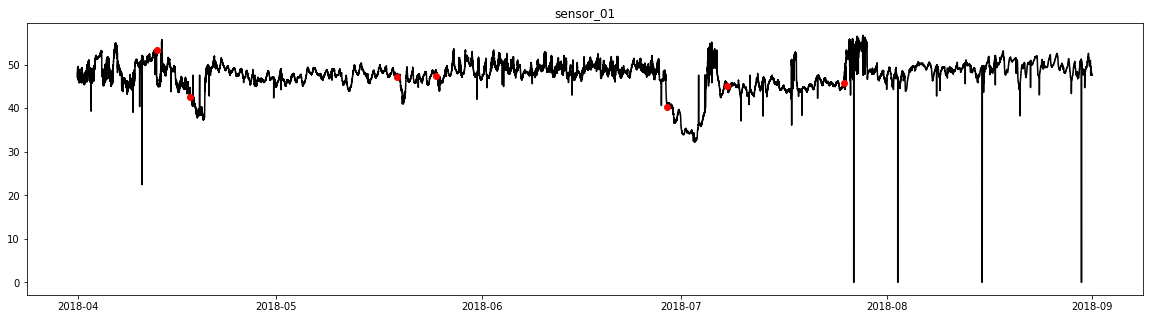

In [7]:
plt.figure(figsize=(20,5))
plt.plot(timestamps, pump_data_sensors_only["sensor_01"], color="black")
plt.plot(broken_markers["timestamp"], broken_markers["sensor_01"], linestyle='none', marker='o', color='red', markersize=6)
plt.title("sensor_01")
plt.show()

## Autoencoder Building

In [8]:
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def flatten_all(input_data):
    new_data = []
    for data in input_data:
        new_data.append(data.flatten())
    return np.array(new_data)

def create_model(input_dim, encoder_layer_details, decoder_layer_details, optimizer, loss="mean_squared_error", metrics=None):
    input_layer = [Input(shape=(input_dim,), name="input")]
    output_layer = [Dense(units=input_dim, activation="sigmoid", name="output")]
    
    layers = input_layer + encoder_layer_details + decoder_layer_details + output_layer
    model = tf.keras.Sequential(layers)
    model.compile(loss=loss, optimizer=optimizer)
    
    return model

# Trains the model
def run_model(model, epochs, batch_size, x_train, x_test):
    model_train = model.fit(
        x_train, x_train,
        epochs=epochs,
        batch_size=batch_size,
        shuffle=False,
        validation_data=(x_test, x_test))
    DataViz.plot_loss(
        model_train.history['loss'],
        model_train.history['val_loss'],
        range(epochs)
    )
    
def find_and_plot_anomalies(model, x_train, x_test, original_dataset, pump_status, broken_markers):
    # Find the max MSE loss during training and set it as the threshold for anomalies
    x_train_pred = model.predict(x_train)
    train_mse_loss = np.mean(np.square(np.abs(x_train_pred - x_train)), axis=1)

    plt.hist(train_mse_loss, bins=50)
    plt.xlabel("Train MSE loss")
    plt.ylabel("# of samples")
    plt.show()

    threshold = np.max(train_mse_loss)
    print("Anomaly MSE threshold: ", threshold)
    
    # Get the MSE loss for test samples and mark those which surpasses the loss threshold as anomalies
    x_test_pred = model.predict(x_test)
    test_mse_loss = np.mean(np.square(np.abs(x_test_pred - x_test)), axis=1)
    test_mse_loss = test_mse_loss.reshape((-1))

    plt.hist(test_mse_loss, bins=50)
    plt.xlabel("Test MSE loss")
    plt.ylabel("# of samples")
    plt.show()

    anomalies = test_mse_loss > threshold
    print("# of anomaly samples: ", np.sum(anomalies))
    print("Indices of anomaly samples: ", np.where(anomalies))
    
    # Get the points that are considered anomalies on the original dataset
    anomaly_points = original_dataset[original_dataset.index.isin(np.where(anomalies)[0])]
    
    # Plot the test data with the anomalies marked
    plt.figure(figsize=(20,5))
    plt.plot(timestamps[part:], original_dataset["sensor_00"], color="black")
    plt.plot(broken_markers["timestamp"], broken_markers["sensor_00"], linestyle='none', marker='X', color='red', markersize=10)
    plt.plot(anomaly_points["timestamp"], anomaly_points["sensor_00"], linestyle='none', marker='o', color='blue', markersize=5)
    plt.title("sensor_00")
    plt.show()
    
    indexes = list(broken_markers.index)
    print(indexes)
    anomalies_indexes = list(np.where(anomalies)[0])
    total = len(anomalies_indexes)
    print("Total anomalies: %s" % (total))
    score = 0
    total_score = 0
    if total > 0:
        max_index = np.max(np.where(anomalies)[0])
        for idx, break_point in enumerate(indexes):
            next_lower_bound = max_index + 1
            current_lower_bound = break_point - 1440 if idx > 0 else 0
            valid_indexes = 0
            if idx < len(indexes) - 1:
                next_lower_bound = indexes[idx+1] - 1440
#             print("Next lower bound: %s", (next_lower_bound))
            for anomaly_index in anomalies_indexes:
                if anomaly_index < next_lower_bound and (anomaly_index >= current_lower_bound):
                    if (anomaly_index >= (break_point - 1440) and anomaly_index <= break_point) or (anomaly_index <= (break_point + 1440) and anomaly_index >= break_point):
                        score += 1
                    valid_indexes += 1

#             print("Valid indexes: %s", (valid_indexes))
#             print(score)
#             print(valid_indexes)
            partial_score = ((score/valid_indexes)/len(indexes))*100 if valid_indexes > 0 else 0
            print(partial_score)
#             print()
            total_score += partial_score
            score = 0
    
    return total_score

x_data = flatten_all(normalize(pump_data_sensors_only.to_numpy()))
part = 5*int(len(x_data)/10)
x_train = np.array(x_data[:part])
x_test = np.array(x_data[part:])

input_shape = x_train[0].shape[0]

original_dataset = pd.DataFrame({"sensor_00": x_train[:, 0], "timestamp": timestamps[part:]})
pump_status = pump_data[part:].reset_index(drop=True)
pump_status = pump_status[["machine_status", "timestamp"]]
pump_status = pd.concat([pd.DataFrame({"sensor_00": x_train[:, 0]}), pump_status], axis=1)
broken_markers = pump_status[pump_status["machine_status"] == "BROKEN"]
broken_markers["timestamp"] = pd.to_datetime(broken_markers["timestamp"])

epochs = 60
models = []

### Model 1

- 3 Hidden dense layers
- No other special aditions

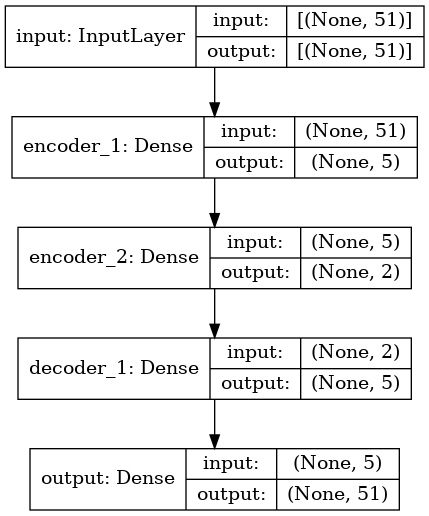

In [9]:
encoder_layer = [
    Dense(
        units=5,
        activation="relu",
#         activity_regularizer=regularizers.l2(1e-3),
        name="encoder_1"
    ),
    Dense(
        units=2,
        activation="relu",
        name="encoder_2"
    ),
]

decoder_layer = [
    Dense(
        units=5,
        activation="relu",
        name="decoder_1"
    )
]

models.append(create_model(input_shape, encoder_layer, decoder_layer, "Adam"))
plot_model(models[-1], show_shapes=True)

Epoch 1/60
861/861 [==============================] - 2s 2ms/step - loss: 0.0621 - val_loss: 0.0028
Epoch 2/60
861/861 [==============================] - 1s 914us/step - loss: 0.0036 - val_loss: 0.0023
Epoch 3/60
861/861 [==============================] - 1s 913us/step - loss: 0.0023 - val_loss: 0.0019
Epoch 4/60
861/861 [==============================] - 1s 919us/step - loss: 0.0016 - val_loss: 0.0016
Epoch 5/60
861/861 [==============================] - 1s 917us/step - loss: 0.0013 - val_loss: 0.0016
Epoch 6/60
861/861 [==============================] - 1s 934us/step - loss: 0.0012 - val_loss: 0.0015
Epoch 7/60
861/861 [==============================] - 1s 917us/step - loss: 0.0012 - val_loss: 0.0015
Epoch 8/60
861/861 [==============================] - 1s 902us/step - loss: 0.0012 - val_loss: 0.0015
Epoch 9/60
861/861 [==============================] - 1s 1ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 10/60
861/861 [==============================] - 1s 912us/step - loss: 0.0011 - 

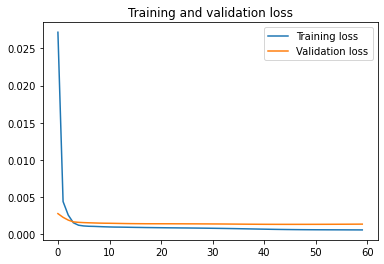

In [10]:
run_model(models[-1], epochs, 128, x_train, x_test)

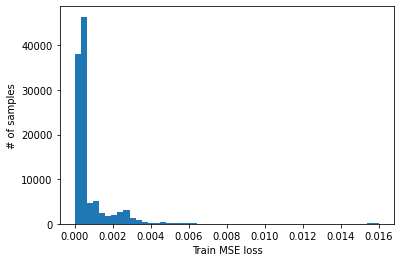

Anomaly MSE threshold:  0.016006669695125177


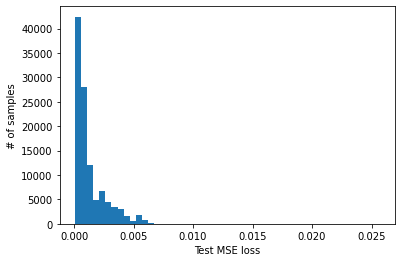

# of anomaly samples:  7
Indices of anomaly samples:  (array([17828, 17829, 17830, 17909, 17910, 17919, 17920]),)


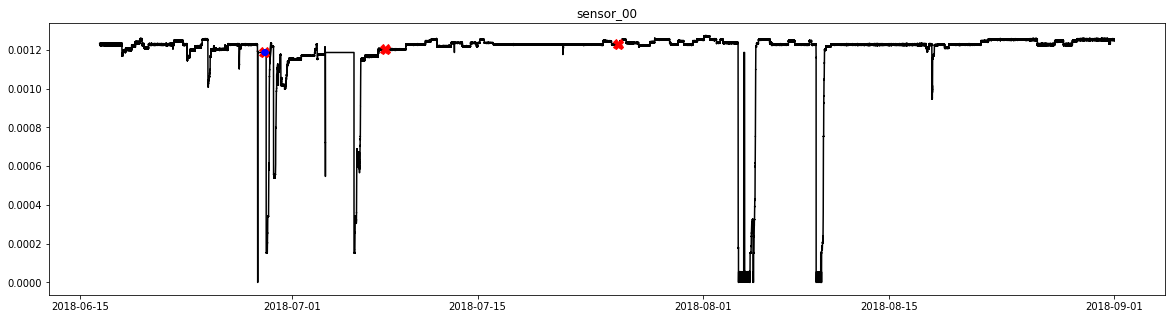

[17880, 30971, 56280]
Total anomalies: 7
33.33333333333333
0
0


33.33333333333333

In [11]:
score = find_and_plot_anomalies(models[-1], x_train, x_test, original_dataset, pump_status, broken_markers)
score

### Model 2

- 3 hidden dense layers
- More neurons per layer

More anomalies detected, but poor generalization (high overfitting).

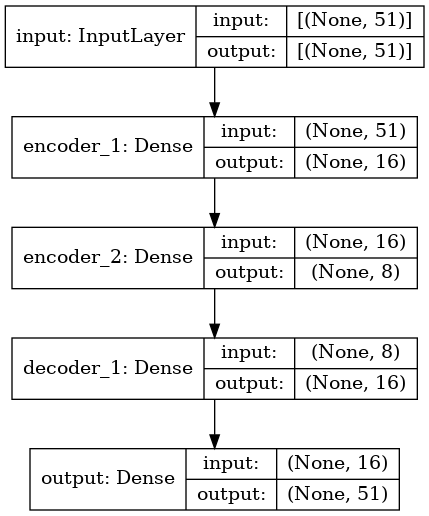

In [12]:
encoder_layer = [
    Dense(
        units=16,
        activation="relu",
        name="encoder_1"
    ),
    Dense(
        units=8,
        activation="relu",
        name="encoder_2"
    ),
]

decoder_layer = [
    Dense(
        units=16,
        activation="relu",
        name="decoder_1"
    )
]

models.append(create_model(input_shape, encoder_layer, decoder_layer, "Adam"))
plot_model(models[-1], show_shapes=True)

Epoch 1/60
861/861 [==============================] - 1s 1ms/step - loss: 0.0448 - val_loss: 0.0027
Epoch 2/60
861/861 [==============================] - 1s 1ms/step - loss: 0.0029 - val_loss: 0.0020
Epoch 3/60
861/861 [==============================] - 1s 1ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 4/60
861/861 [==============================] - 1s 1ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 5/60
861/861 [==============================] - 1s 988us/step - loss: 0.0011 - val_loss: 0.0016
Epoch 6/60
861/861 [==============================] - 1s 997us/step - loss: 0.0010 - val_loss: 0.0015
Epoch 7/60
861/861 [==============================] - 1s 968us/step - loss: 9.5405e-04 - val_loss: 0.0015
Epoch 8/60
861/861 [==============================] - 1s 993us/step - loss: 9.1185e-04 - val_loss: 0.0014
Epoch 9/60
861/861 [==============================] - 1s 1ms/step - loss: 8.6910e-04 - val_loss: 0.0014
Epoch 10/60
861/861 [==============================] - 1s 975us/step - loss: 8.2

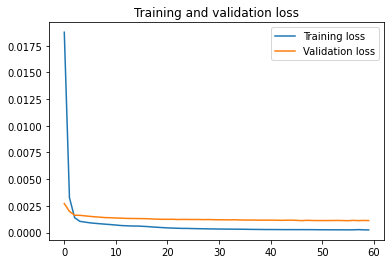

In [13]:
run_model(models[-1], epochs, 128, x_train, x_test)

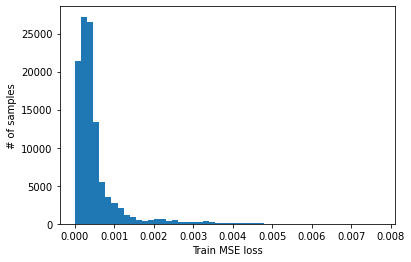

Anomaly MSE threshold:  0.007711543680889914


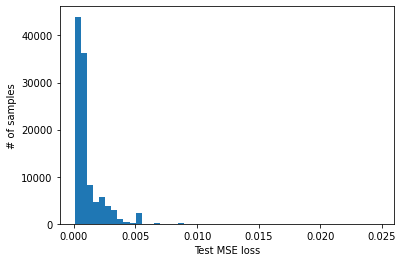

# of anomaly samples:  386
Indices of anomaly samples:  (array([14260, 14261, 14262, 14263, 14264, 14267, 15604, 15605, 15606,
       15607, 15608, 15609, 15610, 15611, 15612, 15613, 15614, 15615,
       15616, 15617, 15618, 15619, 15620, 15621, 15622, 15623, 15624,
       15625, 15626, 15627, 15628, 15629, 15630, 15631, 15632, 15633,
       15634, 15635, 15636, 15637, 15638, 15639, 15640, 15641, 15642,
       15643, 15644, 15645, 15646, 15647, 15648, 15649, 15650, 17190,
       17191, 17192, 17203, 17204, 17205, 17209, 17210, 17213, 17214,
       17215, 17216, 17217, 17218, 17399, 17400, 17401, 17402, 17403,
       17430, 17431, 17432, 17433, 17447, 17448, 17449, 17458, 17459,
       17460, 17461, 17462, 17463, 17464, 17468, 17469, 17470, 17471,
       17472, 17473, 17481, 17482, 17483, 17484, 17485, 17504, 17505,
       17506, 17513, 17514, 17515, 17516, 17517, 17518, 17519, 17523,
       17524, 17525, 17526, 17527, 17545, 17546, 17547, 17548, 17549,
       17550, 17551, 17552, 17553

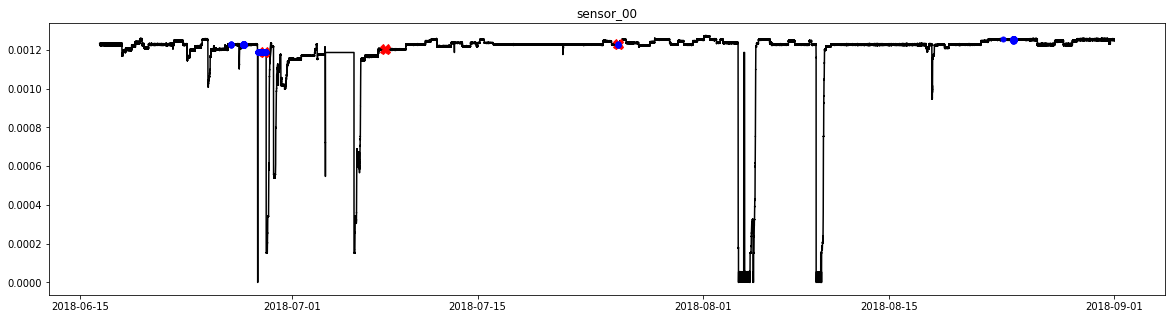

[17880, 30971, 56280]
Total anomalies: 386
27.82969885773624
0
2.5641025641025643


30.393801421838806

In [14]:
find_and_plot_anomalies(models[-1], x_train, x_test, original_dataset, pump_status, broken_markers)

### Model 3

- 3 hidden dense layers
- Added regularization term l1 to reduce overfitting

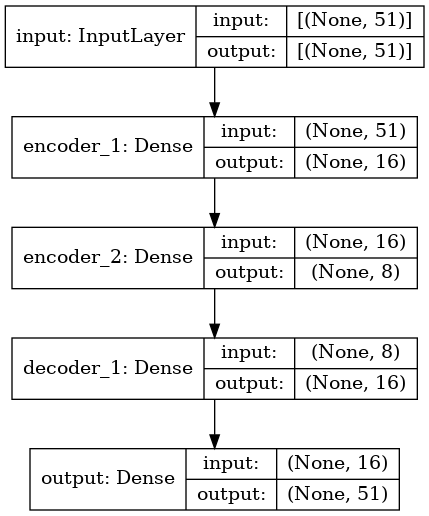

In [15]:
encoder_layer = [
    Dense(
        units=16,
        activation="relu",
        activity_regularizer=regularizers.l1(1e-3),
        name="encoder_1"
    ),
    Dense(
        units=8,
        activation="relu",
        activity_regularizer=regularizers.l1(1e-3),
        name="encoder_2"
    ),
]

decoder_layer = [
    Dense(
        units=16,
        activation="relu",
        activity_regularizer=regularizers.l1(1e-3),
        name="decoder_1"
    )
]

models.append(create_model(input_shape, encoder_layer, decoder_layer, "Adam"))
plot_model(models[-1], show_shapes=True)

Epoch 1/60
861/861 [==============================] - 1s 1ms/step - loss: 0.0656 - val_loss: 0.0109
Epoch 2/60
861/861 [==============================] - 1s 1ms/step - loss: 0.0103 - val_loss: 0.0060
Epoch 3/60
861/861 [==============================] - 1s 1ms/step - loss: 0.0065 - val_loss: 0.0040
Epoch 4/60
861/861 [==============================] - 1s 1ms/step - loss: 0.0046 - val_loss: 0.0034
Epoch 5/60
861/861 [==============================] - 1s 1ms/step - loss: 0.0037 - val_loss: 0.0031
Epoch 6/60
861/861 [==============================] - 1s 1ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 7/60
861/861 [==============================] - 1s 1ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 8/60
861/861 [==============================] - 1s 1ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 9/60
861/861 [==============================] - 1s 1ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 10/60
861/861 [==============================] - 1s 1ms/step - loss: 0.0024 - val_loss: 0.0025

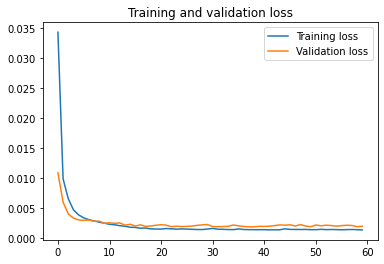

In [16]:
run_model(models[-1], epochs, 128, x_train, x_test)

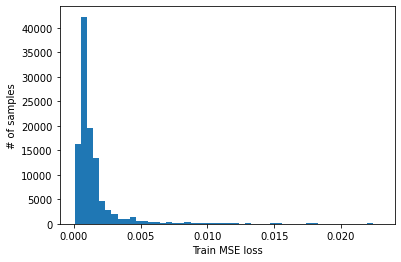

Anomaly MSE threshold:  0.02286390527500601


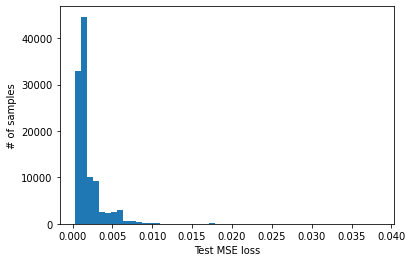

# of anomaly samples:  171
Indices of anomaly samples:  (array([16560, 16561, 16562, 16563, 16564, 16565, 16566, 16567, 16568,
       16569, 16570, 16571, 16572, 16573, 16800, 16801, 16802, 16803,
       16804, 16805, 17214, 17215, 17216, 17217, 17218, 17220, 17221,
       17222, 17223, 17224, 17225, 17545, 17546, 17547, 17548, 17549,
       17550, 17551, 17552, 17553, 17621, 17622, 17623, 17624, 17625,
       17626, 17627, 17628, 17629, 17630, 17631, 17632, 17633, 17634,
       17635, 17636, 17637, 17638, 17639, 17640, 17641, 17642, 17643,
       17644, 17645, 17646, 17647, 17648, 17649, 17650, 17651, 17652,
       17664, 17665, 17666, 17667, 17668, 17669, 17670, 17671, 17672,
       17673, 17674, 17675, 17676, 17677, 17678, 17679, 17680, 17681,
       17735, 17736, 17737, 17738, 17739, 17740, 17765, 17766, 17767,
       17768, 17769, 17770, 17771, 17772, 17773, 17799, 17800, 17801,
       17802, 17803, 17804, 17805, 17823, 17824, 17825, 17826, 17827,
       17828, 17829, 17830, 17831

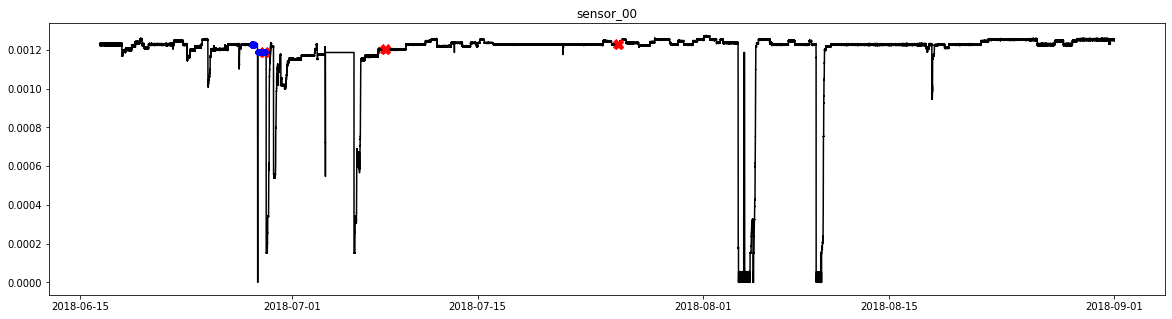

[17880, 30971, 56280]
Total anomalies: 171
33.33333333333333
0
0


33.33333333333333

In [17]:
find_and_plot_anomalies(models[-1], x_train, x_test, original_dataset, pump_status, broken_markers)

### Model 4

- 3 hidden dense layers
- 2 dropout layers

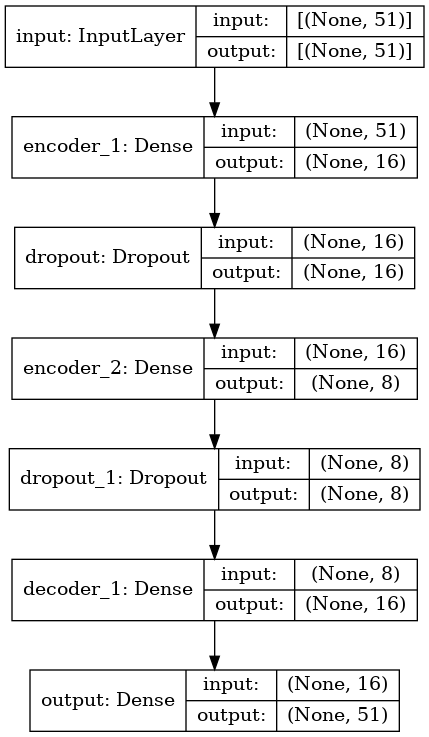

In [18]:
encoder_layer = [
    Dense(
        units=16,
        activation="relu",
#         activity_regularizer=regularizers.l1(1e-3),
        name="encoder_1"
    ),
    Dropout(
        rate=0.3
    ),
    Dense(
        units=8,
        activation="relu",
#         activity_regularizer=regularizers.l1(1e-3),
        name="encoder_2"
    ),
    Dropout(
        rate=0.3
    ),
]

decoder_layer = [
    Dense(
        units=16,
        activation="relu",
#         activity_regularizer=regularizers.l1(1e-3),
        name="decoder_1"
    )
]

models.append(create_model(input_shape, encoder_layer, decoder_layer, "Adam"))
plot_model(models[-1], show_shapes=True)

Epoch 1/60
861/861 [==============================] - 1s 1ms/step - loss: 0.0501 - val_loss: 0.0026
Epoch 2/60
861/861 [==============================] - 1s 957us/step - loss: 0.0036 - val_loss: 0.0022
Epoch 3/60
861/861 [==============================] - 1s 959us/step - loss: 0.0024 - val_loss: 0.0020
Epoch 4/60
861/861 [==============================] - 1s 1ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 5/60
861/861 [==============================] - 1s 931us/step - loss: 0.0015 - val_loss: 0.0016
Epoch 6/60
861/861 [==============================] - 1s 938us/step - loss: 0.0015 - val_loss: 0.0017
Epoch 7/60
861/861 [==============================] - 1s 924us/step - loss: 0.0014 - val_loss: 0.0017
Epoch 8/60
861/861 [==============================] - 1s 935us/step - loss: 0.0014 - val_loss: 0.0017
Epoch 9/60
861/861 [==============================] - 1s 926us/step - loss: 0.0014 - val_loss: 0.0017
Epoch 10/60
861/861 [==============================] - 1s 941us/step - loss: 0.0014 - 

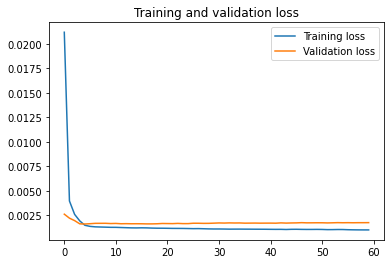

In [19]:
run_model(models[-1], epochs, 128, x_train, x_test)

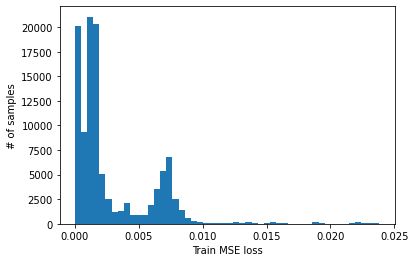

Anomaly MSE threshold:  0.02383628506000304


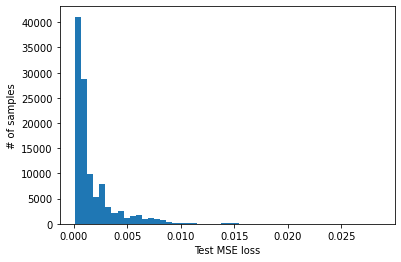

# of anomaly samples:  33
Indices of anomaly samples:  (array([17735, 17736, 17737, 17738, 17739, 17740, 17766, 17767, 17768,
       17769, 17770, 17771, 17772, 17773, 17800, 17801, 17802, 17803,
       17804, 17828, 17829, 17830, 17831, 17832, 17833, 17834, 17835,
       17915, 17916, 17917, 17918, 17919, 17920]),)


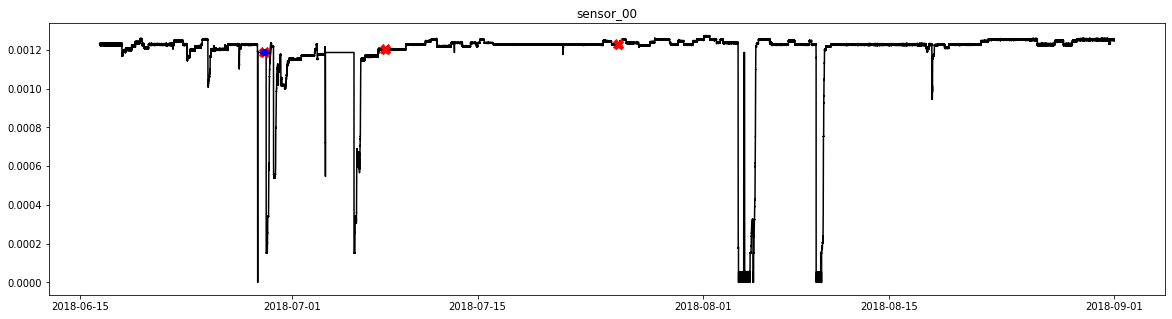

[17880, 30971, 56280]
Total anomalies: 33
33.33333333333333
0
0


33.33333333333333

In [20]:
find_and_plot_anomalies(models[-1], x_train, x_test, original_dataset, pump_status, broken_markers)

### Model 5

- 3 hidden dense layers
- 4 dropout layers

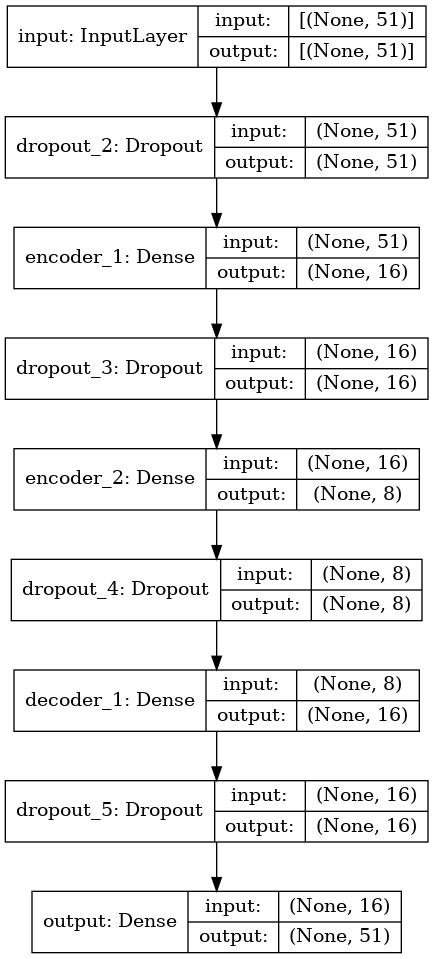

In [21]:
encoder_layer = [
    Dropout(
        rate=0.3
    ),
    Dense(
        units=16,
        activation="relu",
#         activity_regularizer=regularizers.l1(1e-3),
        name="encoder_1"
    ),
    Dropout(
        rate=0.3
    ),
    Dense(
        units=8,
        activation="relu",
#         activity_regularizer=regularizers.l1(1e-3),
        name="encoder_2"
    ),
    Dropout(
        rate=0.3
    ),
]

decoder_layer = [
    Dense(
        units=16,
        activation="relu",
#         activity_regularizer=regularizers.l1(1e-3),
        name="decoder_1"
    ),
    Dropout(
        rate=0.3
    ),
]

models.append(create_model(input_shape, encoder_layer, decoder_layer, "Adam"))
plot_model(models[-1], show_shapes=True)

Epoch 1/60
861/861 [==============================] - 1s 1ms/step - loss: 0.0461 - val_loss: 0.0025
Epoch 2/60
861/861 [==============================] - 1s 1ms/step - loss: 0.0035 - val_loss: 0.0021
Epoch 3/60
861/861 [==============================] - 1s 1ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 4/60
861/861 [==============================] - 1s 1ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 5/60
861/861 [==============================] - 1s 1ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 6/60
861/861 [==============================] - 1s 1ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 7/60
861/861 [==============================] - 1s 1ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 8/60
861/861 [==============================] - 1s 1ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 9/60
861/861 [==============================] - 1s 1ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 10/60
861/861 [==============================] - 1s 1ms/step - loss: 0.0017 - val_loss: 0.0017

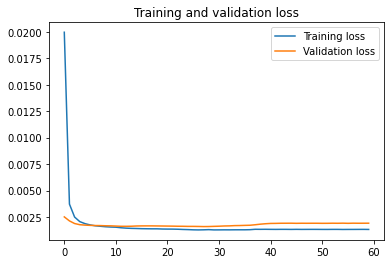

In [22]:
run_model(models[-1], epochs, 128, x_train, x_test)

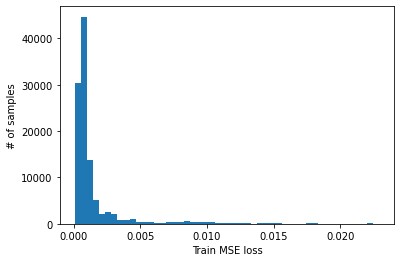

Anomaly MSE threshold:  0.022932025934805294


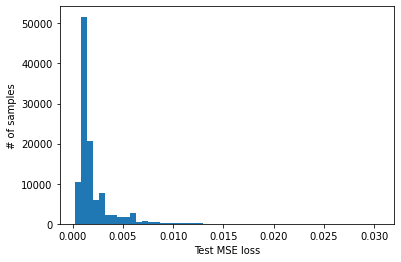

# of anomaly samples:  12
Indices of anomaly samples:  (array([17447, 17449, 17557, 17558, 17559, 17560, 17561, 17562, 17563,
       17564, 17828, 17829]),)


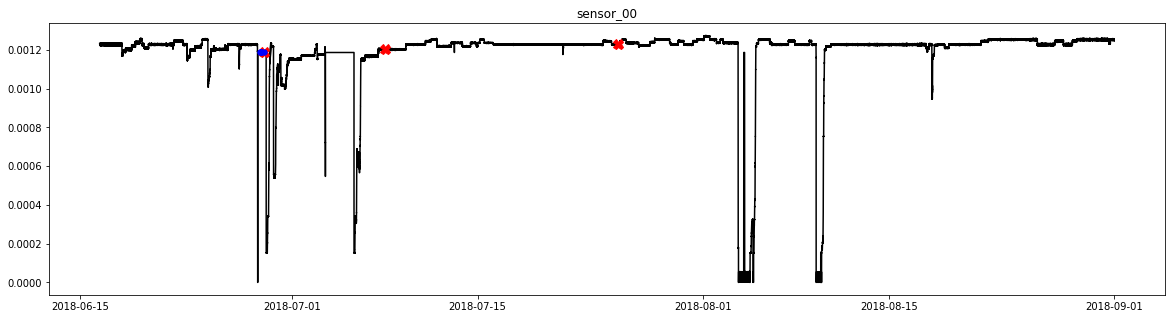

[17880, 30971, 56280]
Total anomalies: 12
33.33333333333333
0
0


33.33333333333333

In [23]:
find_and_plot_anomalies(models[-1], x_train, x_test, original_dataset, pump_status, broken_markers)

### Model 6

- 3 hidden dense layers
- 2 dropout layers
- L1 regularization term

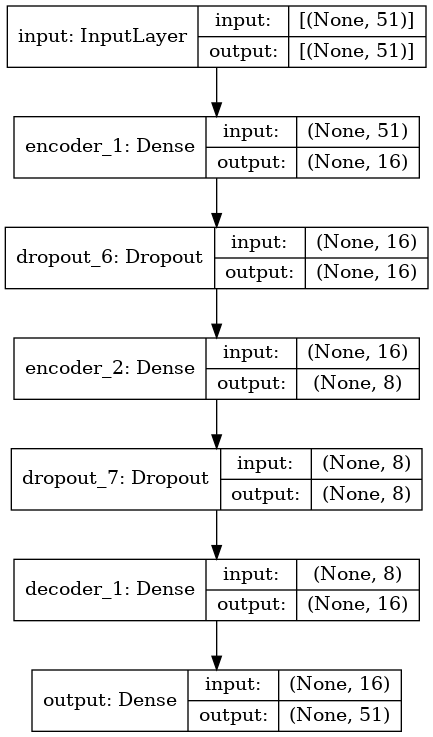

In [24]:
encoder_layer = [
    Dense(
        units=16,
        activation="relu",
        activity_regularizer=regularizers.l1(1e-3),
        name="encoder_1"
    ),
    Dropout(
        rate=0.3
    ),
    Dense(
        units=8,
        activation="relu",
        activity_regularizer=regularizers.l1(1e-3),
        name="encoder_2"
    ),
    Dropout(
        rate=0.3
    ),
]

decoder_layer = [
    Dense(
        units=16,
        activation="relu",
        activity_regularizer=regularizers.l1(1e-3),
        name="decoder_1"
    )
]

models.append(create_model(input_shape, encoder_layer, decoder_layer, "Adam"))
plot_model(models[-1], show_shapes=True)

Epoch 1/60
861/861 [==============================] - 2s 1ms/step - loss: 0.0595 - val_loss: 0.0080
Epoch 2/60
861/861 [==============================] - 1s 1ms/step - loss: 0.0084 - val_loss: 0.0052
Epoch 3/60
861/861 [==============================] - 1s 1ms/step - loss: 0.0060 - val_loss: 0.0044
Epoch 4/60
861/861 [==============================] - 1s 1ms/step - loss: 0.0050 - val_loss: 0.0037
Epoch 5/60
861/861 [==============================] - 1s 1ms/step - loss: 0.0043 - val_loss: 0.0033
Epoch 6/60
861/861 [==============================] - 1s 1ms/step - loss: 0.0038 - val_loss: 0.0032
Epoch 7/60
861/861 [==============================] - 1s 1ms/step - loss: 0.0034 - val_loss: 0.0029
Epoch 8/60
861/861 [==============================] - 1s 1ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 9/60
861/861 [==============================] - 1s 1ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 10/60
861/861 [==============================] - 1s 1ms/step - loss: 0.0028 - val_loss: 0.0029

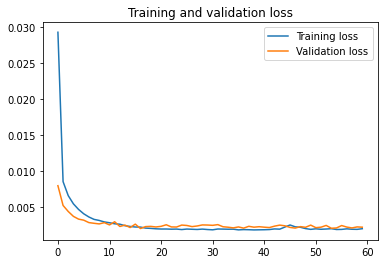

In [25]:
run_model(models[-1], epochs, 128, x_train, x_test)

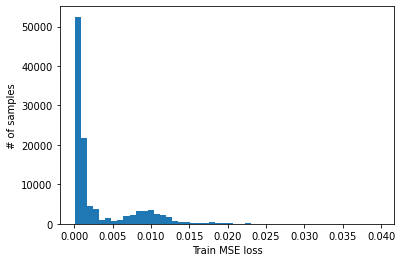

Anomaly MSE threshold:  0.03973667649868024


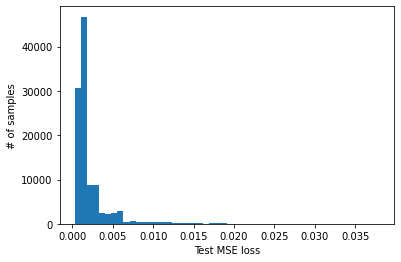

# of anomaly samples:  0
Indices of anomaly samples:  (array([], dtype=int64),)


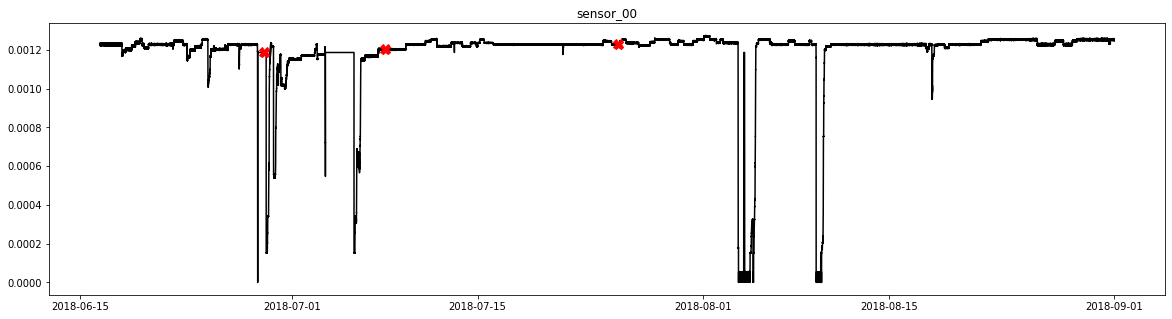

[17880, 30971, 56280]
Total anomalies: 0


0

In [26]:
find_and_plot_anomalies(models[-1], x_train, x_test, original_dataset, pump_status, broken_markers)

### Model 7

- 1 hidden layer

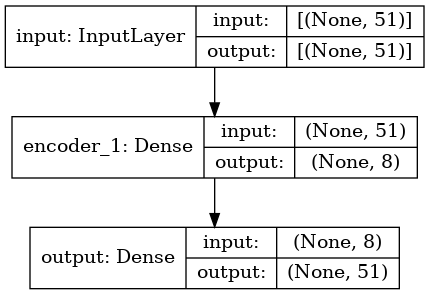

In [27]:
encoder_layer = [
    Dense(
        units=8,
        activation="relu",
#         activity_regularizer=regularizers.l1(1e-3),
        name="encoder_1"
    ),
]

decoder_layer = [
]

models.append(create_model(input_shape, encoder_layer, decoder_layer, "Adam"))
plot_model(models[-1], show_shapes=True)

Epoch 1/60
861/861 [==============================] - 1s 968us/step - loss: 0.0770 - val_loss: 0.0031
Epoch 2/60
861/861 [==============================] - 1s 835us/step - loss: 0.0049 - val_loss: 0.0021
Epoch 3/60
861/861 [==============================] - 1s 874us/step - loss: 0.0027 - val_loss: 0.0018
Epoch 4/60
861/861 [==============================] - 1s 910us/step - loss: 0.0018 - val_loss: 0.0017
Epoch 5/60
861/861 [==============================] - 1s 870us/step - loss: 0.0014 - val_loss: 0.0016
Epoch 6/60
861/861 [==============================] - 1s 830us/step - loss: 0.0013 - val_loss: 0.0016
Epoch 7/60
861/861 [==============================] - 1s 826us/step - loss: 0.0013 - val_loss: 0.0016
Epoch 8/60
861/861 [==============================] - 1s 807us/step - loss: 0.0012 - val_loss: 0.0016
Epoch 9/60
861/861 [==============================] - 1s 800us/step - loss: 0.0012 - val_loss: 0.0015
Epoch 10/60
861/861 [==============================] - 1s 807us/step - loss: 0.001

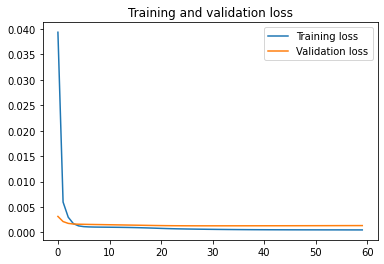

In [28]:
run_model(models[-1], epochs, 128, x_train, x_test)

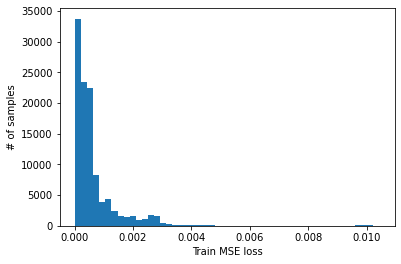

Anomaly MSE threshold:  0.010433725475456087


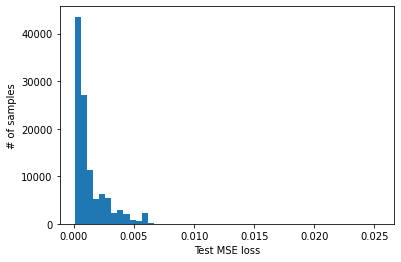

# of anomaly samples:  242
Indices of anomaly samples:  (array([14260, 14261, 14262, 14263, 14264, 15615, 15617, 15618, 15619,
       15621, 15623, 15624, 15625, 15626, 15627, 15628, 15629, 15630,
       15631, 15632, 15633, 15634, 15635, 15636, 15637, 15638, 15639,
       15640, 15641, 15642, 15643, 15644, 15645, 15646, 15647, 15648,
       15649, 15650, 17190, 17191, 17192, 17203, 17204, 17205, 17214,
       17215, 17216, 17217, 17218, 17399, 17400, 17401, 17402, 17403,
       17430, 17431, 17432, 17433, 17447, 17448, 17449, 17458, 17459,
       17460, 17461, 17462, 17463, 17464, 17468, 17469, 17470, 17471,
       17472, 17473, 17481, 17482, 17483, 17484, 17485, 17504, 17505,
       17506, 17514, 17515, 17516, 17517, 17518, 17519, 17524, 17525,
       17526, 17527, 17546, 17547, 17548, 17549, 17550, 17551, 17552,
       17553, 17557, 17558, 17559, 17560, 17561, 17562, 17563, 17564,
       17729, 17730, 17731, 17735, 17736, 17737, 17738, 17739, 17740,
       17760, 17761, 17762, 17766

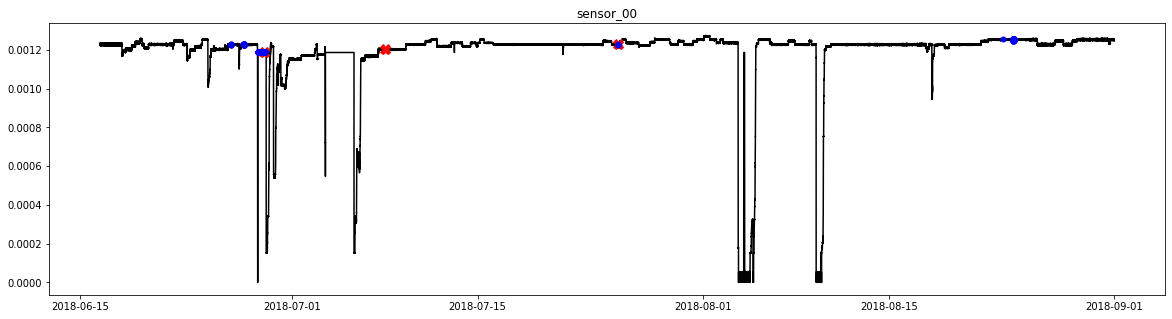

[17880, 30971, 56280]
Total anomalies: 242
26.136363636363637
0
1.5151515151515151


27.651515151515152

In [29]:
find_and_plot_anomalies(models[-1], x_train, x_test, original_dataset, pump_status, broken_markers)

### Model 8

- 1 hidden layer
- L1 regularization

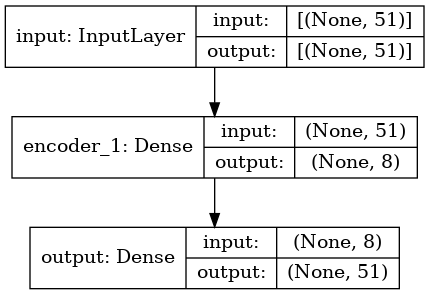

In [30]:
encoder_layer = [
    Dense(
        units=8,
        activation="relu",
        activity_regularizer=regularizers.l1(1e-3),
        name="encoder_1"
    ),
]

decoder_layer = [
]

models.append(create_model(input_shape, encoder_layer, decoder_layer, "Adam"))
plot_model(models[-1], show_shapes=True)

Epoch 1/60
861/861 [==============================] - 1s 1ms/step - loss: 0.0738 - val_loss: 0.0092
Epoch 2/60
861/861 [==============================] - 1s 839us/step - loss: 0.0092 - val_loss: 0.0072
Epoch 3/60
861/861 [==============================] - 1s 828us/step - loss: 0.0068 - val_loss: 0.0061
Epoch 4/60
861/861 [==============================] - 1s 821us/step - loss: 0.0057 - val_loss: 0.0053
Epoch 5/60
861/861 [==============================] - 1s 807us/step - loss: 0.0049 - val_loss: 0.0046
Epoch 6/60
861/861 [==============================] - 1s 824us/step - loss: 0.0042 - val_loss: 0.0041
Epoch 7/60
861/861 [==============================] - 1s 968us/step - loss: 0.0036 - val_loss: 0.0035
Epoch 8/60
861/861 [==============================] - 1s 831us/step - loss: 0.0030 - val_loss: 0.0031
Epoch 9/60
861/861 [==============================] - 1s 826us/step - loss: 0.0026 - val_loss: 0.0027
Epoch 10/60
861/861 [==============================] - 1s 826us/step - loss: 0.0023 

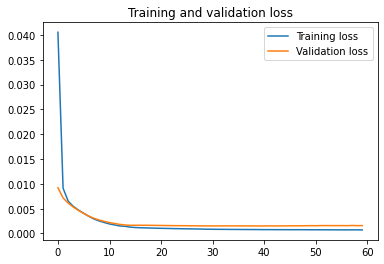

In [31]:
run_model(models[-1], epochs, 128, x_train, x_test)

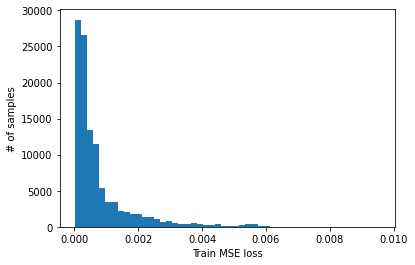

Anomaly MSE threshold:  0.009546361346286569


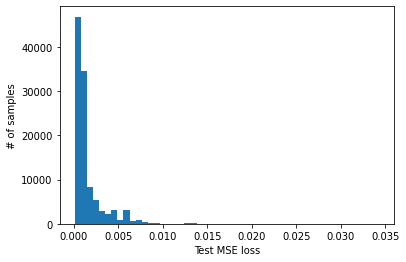

# of anomaly samples:  620
Indices of anomaly samples:  (array([14260, 14261, 14262, 14263, 14264, 14266, 14267, 14268, 14269,
       14270, 14271, 14272, 14273, 14274, 14275, 14289, 14290, 15186,
       15187, 15604, 15605, 15606, 15607, 15608, 15609, 15610, 15611,
       15612, 15613, 15614, 15615, 15616, 15617, 15618, 15619, 15620,
       15621, 15622, 15623, 15624, 15625, 15626, 15627, 15628, 15629,
       15630, 15631, 15632, 15633, 15634, 15635, 15636, 15637, 15638,
       15639, 15640, 15641, 15642, 15643, 15644, 15645, 15646, 15647,
       15648, 15649, 15650, 17190, 17191, 17192, 17203, 17204, 17205,
       17209, 17210, 17214, 17215, 17216, 17217, 17218, 17220, 17221,
       17222, 17223, 17224, 17225, 17399, 17400, 17401, 17402, 17403,
       17430, 17431, 17432, 17433, 17447, 17448, 17449, 17458, 17459,
       17460, 17461, 17462, 17463, 17464, 17468, 17469, 17470, 17471,
       17472, 17473, 17481, 17482, 17483, 17484, 17485, 17504, 17505,
       17506, 17513, 17514, 17515

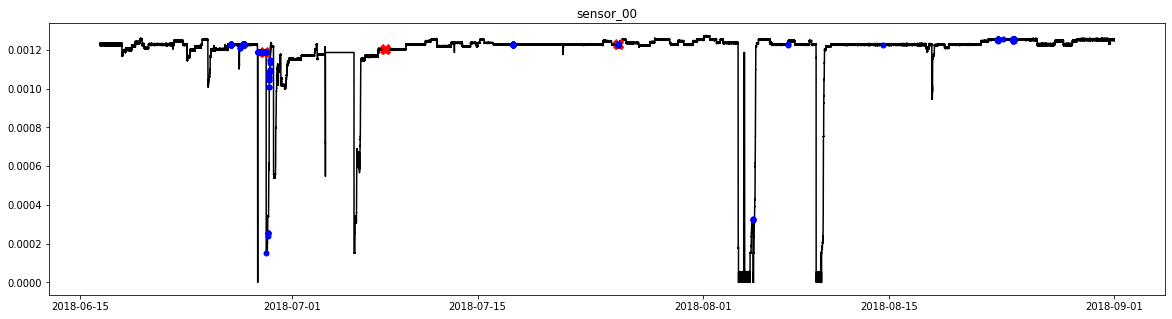

[17880, 30971, 56280]
Total anomalies: 620
29.036458333333332
0.0
2.4561403508771926


31.492598684210524

In [32]:
find_and_plot_anomalies(models[-1], x_train, x_test, original_dataset, pump_status, broken_markers)

### Model 9

- 1 hidden layer
- 2 dropout layers

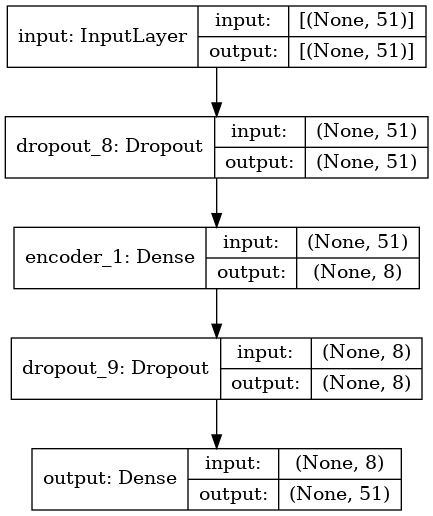

In [33]:
encoder_layer = [
    Dropout(
        rate=0.3
    ),
    Dense(
        units=8,
        activation="relu",
#         activity_regularizer=regularizers.l1(1e-3),
        name="encoder_1"
    ),
    Dropout(
        rate=0.3
    )
]

decoder_layer = [
]

models.append(create_model(input_shape, encoder_layer, decoder_layer, "Adam"))
plot_model(models[-1], show_shapes=True)

Epoch 1/60
861/861 [==============================] - 1s 1ms/step - loss: 0.0562 - val_loss: 0.0034
Epoch 2/60
861/861 [==============================] - 1s 873us/step - loss: 0.0063 - val_loss: 0.0025
Epoch 3/60
861/861 [==============================] - 1s 858us/step - loss: 0.0042 - val_loss: 0.0021
Epoch 4/60
861/861 [==============================] - 1s 813us/step - loss: 0.0035 - val_loss: 0.0020
Epoch 5/60
861/861 [==============================] - 1s 830us/step - loss: 0.0030 - val_loss: 0.0019
Epoch 6/60
861/861 [==============================] - 1s 813us/step - loss: 0.0028 - val_loss: 0.0018
Epoch 7/60
861/861 [==============================] - 1s 815us/step - loss: 0.0026 - val_loss: 0.0017
Epoch 8/60
861/861 [==============================] - 1s 833us/step - loss: 0.0024 - val_loss: 0.0017
Epoch 9/60
861/861 [==============================] - 1s 836us/step - loss: 0.0022 - val_loss: 0.0017
Epoch 10/60
861/861 [==============================] - 1s 826us/step - loss: 0.0020 

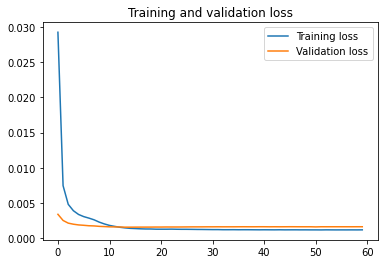

In [34]:
run_model(models[-1], epochs, 128, x_train, x_test)

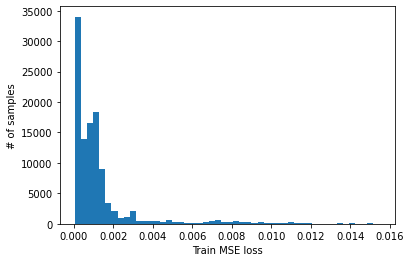

Anomaly MSE threshold:  0.015458379587629216


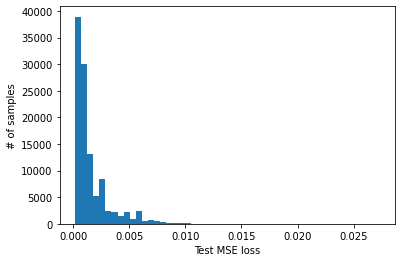

# of anomaly samples:  38
Indices of anomaly samples:  (array([17557, 17558, 17559, 17560, 17561, 17562, 17563, 17564, 17826,
       17827, 17828, 17829, 17830, 17846, 17848, 17849, 17850, 17851,
       17898, 17899, 17900, 17901, 17902, 17903, 17904, 17905, 17906,
       17907, 17908, 17909, 17910, 17911, 17915, 17916, 17917, 17918,
       17919, 17920]),)


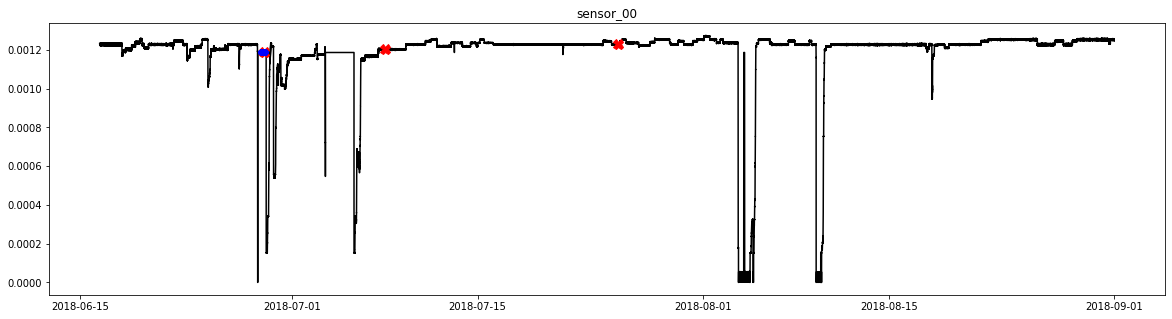

[17880, 30971, 56280]
Total anomalies: 38
33.33333333333333
0
0


33.33333333333333

In [35]:
find_and_plot_anomalies(models[-1], x_train, x_test, original_dataset, pump_status, broken_markers)

### Model 10

- 1 Hidden layer

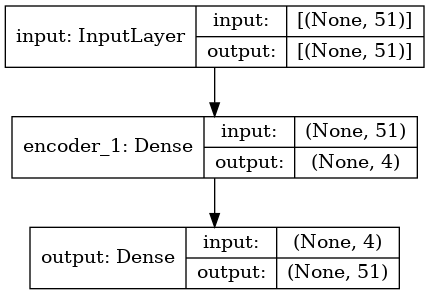

In [36]:
encoder_layer = [
    Dense(
        units=4,
        activation="relu",
#         activity_regularize|r=regularizers.l1(1e-3),
        name="encoder_1"
    ),
]

decoder_layer = [
]

models.append(create_model(input_shape, encoder_layer, decoder_layer, "Adam"))
plot_model(models[-1], show_shapes=True)

Epoch 1/60
861/861 [==============================] - 1s 1ms/step - loss: 0.0722 - val_loss: 0.0036
Epoch 2/60
861/861 [==============================] - 1s 871us/step - loss: 0.0068 - val_loss: 0.0028
Epoch 3/60
861/861 [==============================] - 1s 870us/step - loss: 0.0051 - val_loss: 0.0025
Epoch 4/60
861/861 [==============================] - 1s 871us/step - loss: 0.0040 - val_loss: 0.0022
Epoch 5/60
861/861 [==============================] - 1s 871us/step - loss: 0.0030 - val_loss: 0.0019
Epoch 6/60
861/861 [==============================] - 1s 869us/step - loss: 0.0021 - val_loss: 0.0017
Epoch 7/60
861/861 [==============================] - 1s 862us/step - loss: 0.0015 - val_loss: 0.0016
Epoch 8/60
861/861 [==============================] - 1s 868us/step - loss: 0.0013 - val_loss: 0.0016
Epoch 9/60
861/861 [==============================] - 1s 1ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 10/60
861/861 [==============================] - 1s 895us/step - loss: 0.0012 - 

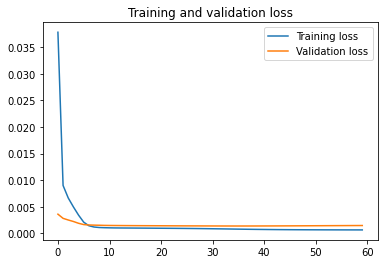

In [37]:
run_model(models[-1], epochs, 128, x_train, x_test)

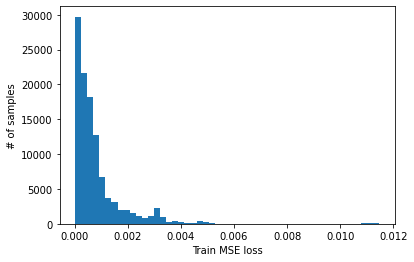

Anomaly MSE threshold:  0.011468917723479672


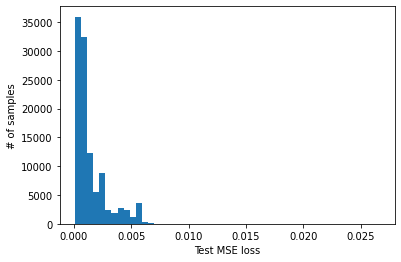

# of anomaly samples:  184
Indices of anomaly samples:  (array([15641, 15644, 15645, 15646, 15647, 15648, 15649, 15650, 17190,
       17191, 17192, 17214, 17215, 17216, 17217, 17218, 17399, 17400,
       17401, 17402, 17403, 17430, 17431, 17432, 17433, 17447, 17448,
       17449, 17468, 17469, 17470, 17471, 17472, 17473, 17504, 17505,
       17506, 17518, 17524, 17525, 17526, 17527, 17547, 17548, 17549,
       17550, 17551, 17552, 17553, 17557, 17558, 17559, 17560, 17561,
       17562, 17563, 17564, 17730, 17731, 17736, 17737, 17738, 17739,
       17740, 17760, 17761, 17762, 17766, 17767, 17768, 17769, 17770,
       17771, 17772, 17773, 17795, 17796, 17800, 17801, 17802, 17803,
       17804, 17824, 17825, 17826, 17827, 17828, 17829, 17830, 17831,
       17832, 17833, 17834, 17835, 17846, 17847, 17848, 17849, 17850,
       17851, 17897, 17898, 17899, 17900, 17901, 17902, 17903, 17904,
       17905, 17906, 17907, 17908, 17909, 17910, 17911, 17915, 17916,
       17917, 17918, 17919, 17920

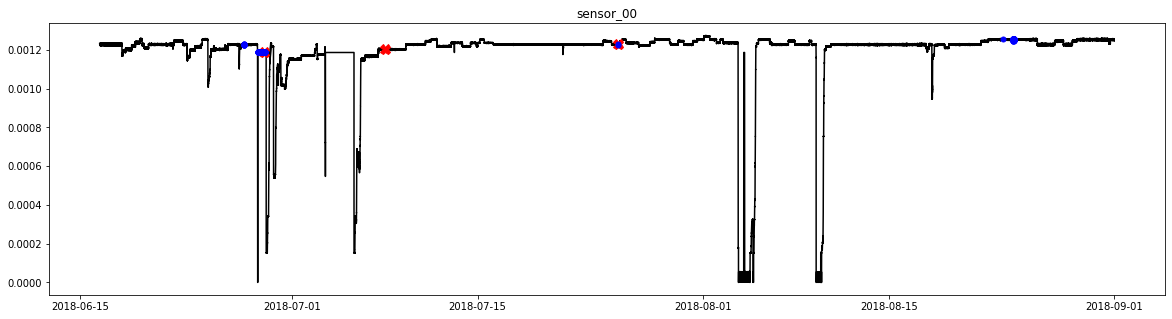

[17880, 30971, 56280]
Total anomalies: 184
31.129476584022036
0
1.0582010582010581


32.18767764222309

In [38]:
find_and_plot_anomalies(models[-1], x_train, x_test, original_dataset, pump_status, broken_markers)

### Model 11

- 1 hidden layer
- Reg term L1

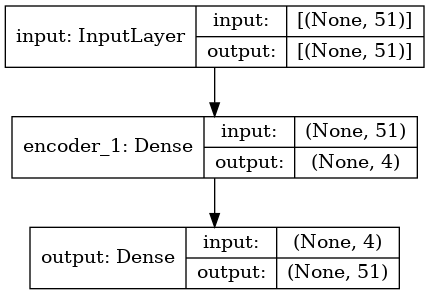

In [39]:
encoder_layer = [
    Dense(
        units=4,
        activation="relu",
        activity_regularizer=regularizers.l1(1e-3),
        name="encoder_1"
    ),
]

decoder_layer = [
]

models.append(create_model(input_shape, encoder_layer, decoder_layer, "Adam"))
plot_model(models[-1], show_shapes=True)

Epoch 1/60
861/861 [==============================] - 1s 1ms/step - loss: 0.1122 - val_loss: 0.0079
Epoch 2/60
861/861 [==============================] - 1s 907us/step - loss: 0.0099 - val_loss: 0.0064
Epoch 3/60
861/861 [==============================] - 1s 902us/step - loss: 0.0077 - val_loss: 0.0053
Epoch 4/60
861/861 [==============================] - 1s 890us/step - loss: 0.0059 - val_loss: 0.0043
Epoch 5/60
861/861 [==============================] - 1s 898us/step - loss: 0.0045 - val_loss: 0.0038
Epoch 6/60
861/861 [==============================] - 1s 1ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 7/60
861/861 [==============================] - 1s 890us/step - loss: 0.0032 - val_loss: 0.0032
Epoch 8/60
861/861 [==============================] - 1s 890us/step - loss: 0.0029 - val_loss: 0.0029
Epoch 9/60
861/861 [==============================] - 1s 904us/step - loss: 0.0027 - val_loss: 0.0027
Epoch 10/60
861/861 [==============================] - 1s 914us/step - loss: 0.0025 - 

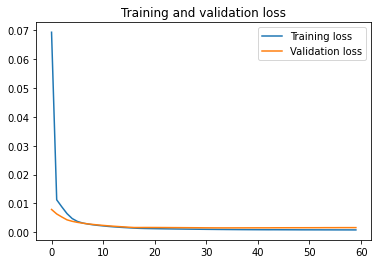

In [40]:
run_model(models[-1], epochs, 128, x_train, x_test)

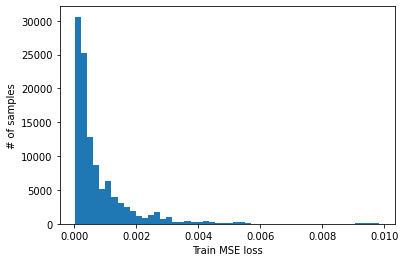

Anomaly MSE threshold:  0.00983736261305638


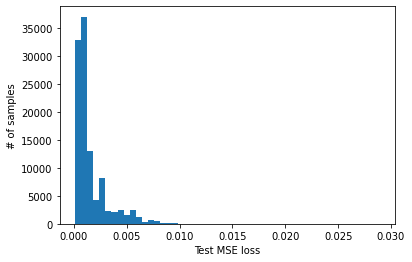

# of anomaly samples:  357
Indices of anomaly samples:  (array([14260, 14261, 14262, 14263, 14264, 14266, 14267, 15186, 15187,
       15604, 15605, 15606, 15607, 15608, 15609, 15610, 15611, 15612,
       15613, 15614, 15615, 15616, 15617, 15618, 15619, 15620, 15621,
       15622, 15623, 15624, 15625, 15626, 15627, 15628, 15629, 15630,
       15631, 15632, 15633, 15634, 15635, 15636, 15637, 15638, 15639,
       15640, 15641, 15642, 15643, 15644, 15645, 15646, 15647, 15648,
       15649, 15650, 17190, 17191, 17192, 17203, 17204, 17205, 17209,
       17214, 17215, 17216, 17217, 17218, 17220, 17221, 17222, 17223,
       17224, 17225, 17399, 17400, 17401, 17402, 17403, 17430, 17431,
       17432, 17433, 17447, 17448, 17449, 17458, 17459, 17460, 17461,
       17462, 17463, 17464, 17468, 17469, 17470, 17471, 17472, 17473,
       17481, 17482, 17483, 17484, 17485, 17504, 17505, 17506, 17514,
       17515, 17516, 17517, 17518, 17519, 17524, 17525, 17526, 17527,
       17546, 17547, 17548, 17549

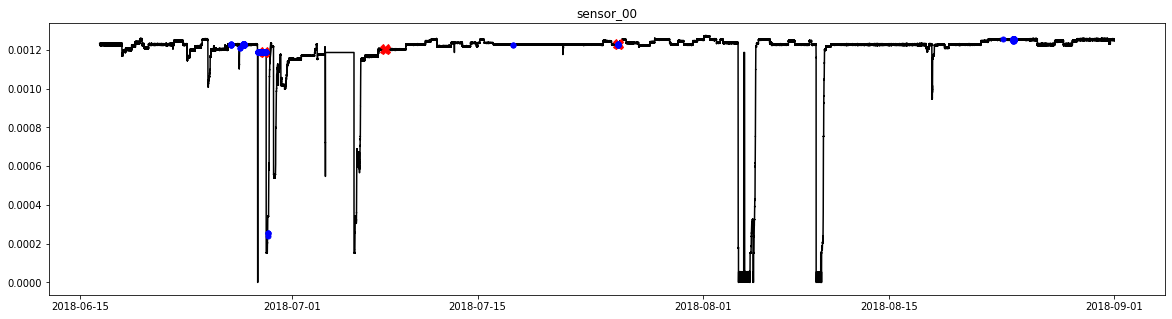

[17880, 30971, 56280]
Total anomalies: 357
26.642771804062125
0.0
3.508771929824561


30.151543733886687

In [41]:
find_and_plot_anomalies(models[-1], x_train, x_test, original_dataset, pump_status, broken_markers)